**If you just want to see the cool results, look for starred (\*) headers.**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

PATH = os.path.abspath('..')
sys.path.append(f'/home/john/projects/convnet-demo/src')
from multiclass import *

# Loading a pretrained network

In [2]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

display(df.sample(5, random_state=256))

oh_p50
objID                        
1237662302449500701  8.952116
1237665024905248887  8.724266
1237671939798073517  8.959539
1237662640658121002  8.992033
1237657611805196484  8.326750

In [3]:
# test-train split
n = len(df)
val_idxs = get_cv_idxs(n, val_pct=0.2, seed=256)

In [4]:
arch = resnet34
sz = 128
bs = 128

# get data transformers and ClassifierData object (for regression)
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

n_batch = len(data.trn_y) // bs

# initialize pretrained network
learn = ConvLearner.pretrained(arch, data)
learn.crit = rmse

In [5]:
learn.load('resnet34-single_sz128-bs128')
learn.crit = rmse

In [6]:
# new batchsize
bs = 8

learn.data_.bs = bs

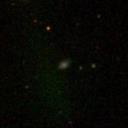

In [7]:
fn = PATH + '/' + data.val_ds.fnames[0]
img = PIL.Image.open(fn); 
img

As a reminder of how this is trained, below is an example of its performance on real test SDSS data:

![Example image](../../../galaxy-cnns/docs/figures/example.png)

# Model activations for an example training image

See [this notebook](https://github.com/kheyer/ML-DL-Projects/tree/master/Dog%20Breed%20CNN%20Visualizations)

In [8]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
model=learn.model
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [9]:
def return_sequential(layer_num, model):
    return nn.Sequential(*list(model.children())[:layer_num])

class get_activation_layer(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.layer_models = []
        for i in range(len(self.model)):
             self.layer_models.append(return_sequential(i, self.model))
    def forward(self, x):
        self.outputs = []
        for i in range(len(self.model)):
            self.outputs.append(self.layer_models[i](x))
        return self.outputs

/home/john/projects/convnets-galaxy-metallicities-tsne/train/1237665441525596194.jpg


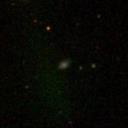

In [10]:
print(fn)
PIL.Image.open(fn)

In [11]:
img = val_tfms(open_image(fn))
                
tmp_model = get_activation_layer(model)
layer_outputs = tmp_model(V(img)[None])

In [12]:
# see which ones are conv layers and which are not
[i.dim() for i in layer_outputs]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2]

In [13]:
# keep 
layer_outputs = [i for i in layer_outputs if i.dim() == 4]

In [14]:
for i, layer in enumerate(layer_outputs):
    features = layer.data
    images = features.numpy()[0]
    print(images.shape)

(3, 128, 128)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 32, 32)
(64, 32, 32)
(128, 16, 16)
(256, 8, 8)
(512, 4, 4)
(1024, 1, 1)


I could, for instance, look at layer `5` (the 6th since they're 0-indexed) for every single galaxy

In [15]:
features = layer_outputs[5].data.numpy().squeeze()

In [16]:
features.max(axis=(1, 2))

array([ 3.42517,  0.95758,  3.11814,  4.32232,  3.05482,  4.13525,  3.23991,  1.42954,  0.67904,  3.12811,
        1.78427,  2.77429,  1.73707,  6.06693,  1.09531,  1.43037,  3.54935,  2.41179, 10.13811,  3.35701,
        2.958  ,  6.75302,  3.47021,  3.69534,  2.11588,  3.18596,  3.14577,  4.34217,  5.07755,  2.23623,
        3.05853,  1.17299,  4.48932,  3.60869,  1.28006,  2.28212,  1.68795,  2.83732,  1.39326,  1.4646 ,
        2.22173,  3.07451,  1.52146,  4.04845,  4.38363,  3.06067,  2.06208,  3.26379,  2.54119,  1.3233 ,
        2.57523,  1.62153,  3.08776,  3.16242,  1.17012,  2.01694,  5.10893,  1.03842,  2.3266 ,  1.07003,
        3.56972,  1.12239,  4.29574,  1.36398], dtype=float32)

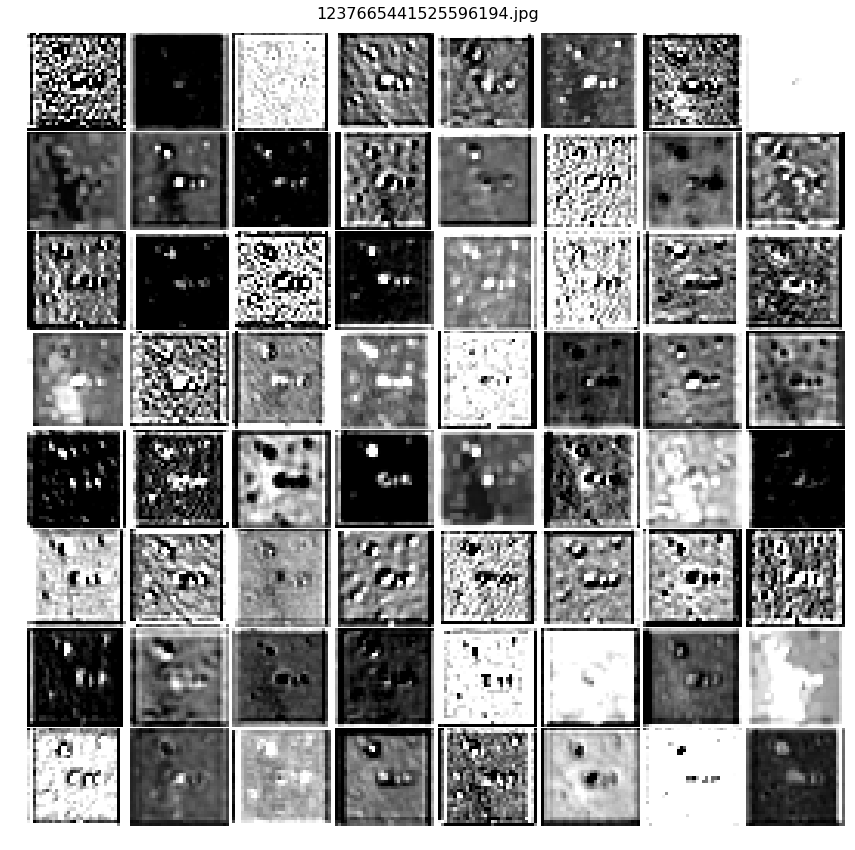

In [17]:
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[i], origin='upper', vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01, top=0.95)
fig.suptitle(f'{os.path.basename(fn)}', fontsize=16);

# Make method for analyzing activations in the sixth layer

In [19]:
def retrieve_layer(fn, layer=6, training=True):
    """Given a file name, get all of the sixth layer activations"""
    img = trn_tfms(open_image(fn)) if training else val_tfms(open_image(fn))
                
    tmp_model = get_activation_layer(model)
    layer_outputs = tmp_model(V(img)[None])
    
    return layer_outputs[layer - 1].data.numpy().squeeze()

Each one of these activations represents the same particular set of linear operations. Since in the image above, the sixth one (again index `5`) looks interesting, let's now grab that.

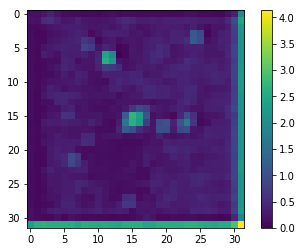

In [20]:
# first validation image
acts = retrieve_layer(fn, layer=6)
plt.imshow(acts[5])
plt.colorbar()

Repeat with a validation image

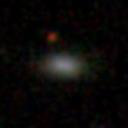

In [21]:
fn = PATH + '/' + data.val_ds.fnames[3]
PIL.Image.open(fn)

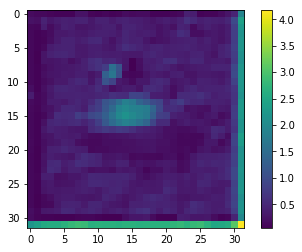

In [25]:
# first training image
acts = retrieve_layer(fn, layer=6)
plt.imshow(acts[5])
plt.colorbar()

# Store a stack of layer-6 activations for all validation images

In [26]:
len(data.val_ds)

80

So this should be 80 x 64 x 32 x 32, or about 5 million elements. Should be okay!

In [27]:
all_layer6 = np.empty((80, 64, 32, 32), dtype=np.float32)

In [28]:
from numba import jit, njit

In [32]:
fns = np.array([f'{PATH}/{data.val_ds.fnames[i]}' for i in range(len(data.val_ds))])

def load_all_layer6():
    """Loads in all of the layer-6 activations into a 4d tensor.
    
    TODO: make this more modular by allowing for arguments `ds`, and
    perhaps also allowing for an `out` array where data would be stored.
    """
    all_layer6 = np.empty((80, 64, 32, 32), dtype=np.float32)
    
    for i in range(len(data.val_ds)):
        all_layer6[i] = retrieve_layer(fns[i], layer=6, training=False)
    
    return all_layer6

In [33]:
all_layer6 = load_all_layer6()

In [34]:
all_layer6.shape

(80, 64, 32, 32)

Let's look at a few of the 64 different channels

## Layer 6, channel 6

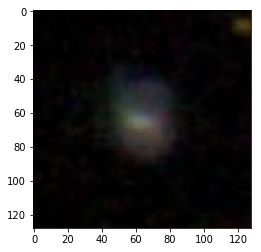

In [35]:
# random image
i = 32
img = open_image(fns[i])
plt.imshow(img)

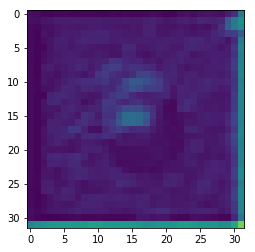

In [36]:
# channel 6 -> j=5
j = 5
plt.imshow(all_layer6[i, j, :], vmin=0, vmax=5)

In [37]:
def plot_lay6_image_pairs(idx, chan,):
    """Given inputs `idx` (which is the index number) and `chan`
    (the channel for that layer group), plots the original image
    and activations in that channel group.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
    ax1.imshow(open_image(fns[idx]))
    ax2.imshow(all_layer6[idx, chan, :], vmin=0, vmax=np.max(all_layer6[:, chan, :]), cmap='gray')
    
    ax1.axis('off')
    ax2.axis('off')
    
    fig.suptitle(f'Validation Image {idx+1}, channel {chan+1}') # note these are *not* zero-indexed
    fig.subplots_adjust(wspace=0.02)
    plt.show()

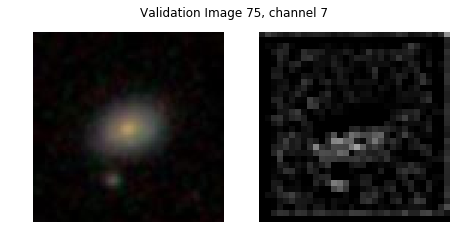

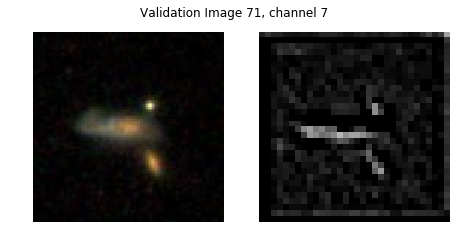

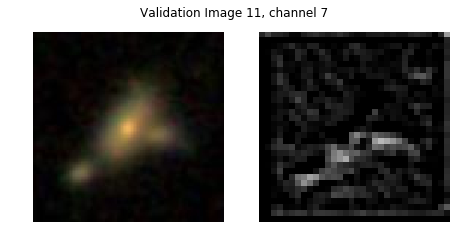

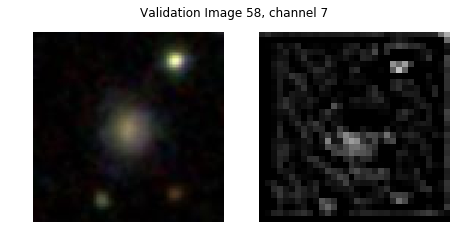

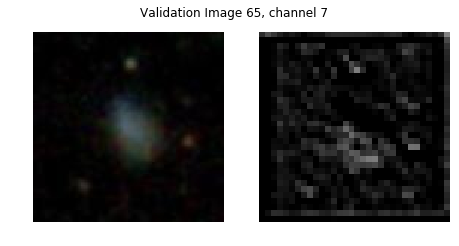

In [39]:
# channel 6
chan = 6
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan)

## Layer 6, channel 2

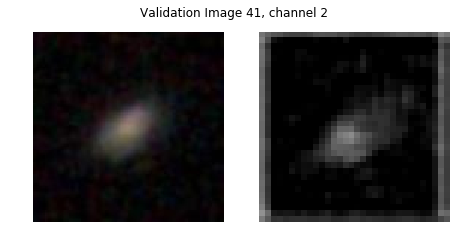

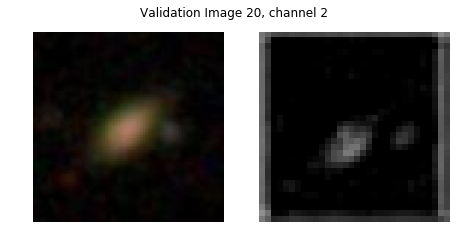

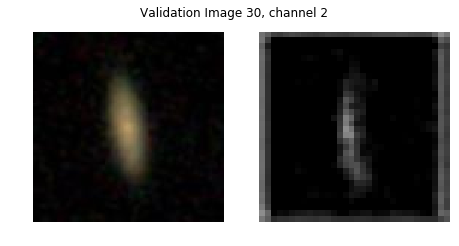

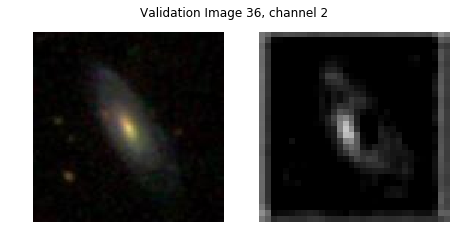

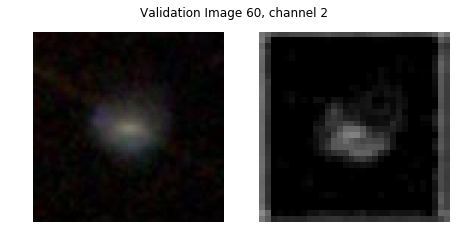

In [40]:
chan = 2
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan - 1)

## (*) Inspect Validation image 42

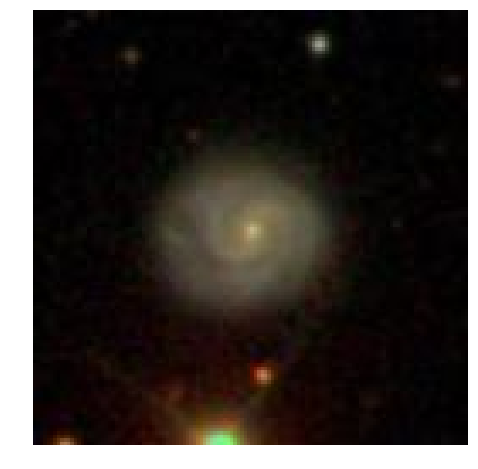

In [41]:
plt.figure(figsize=(8, 8))
plt.imshow(open_image(fns[42 - 1]))
plt.axis("off");

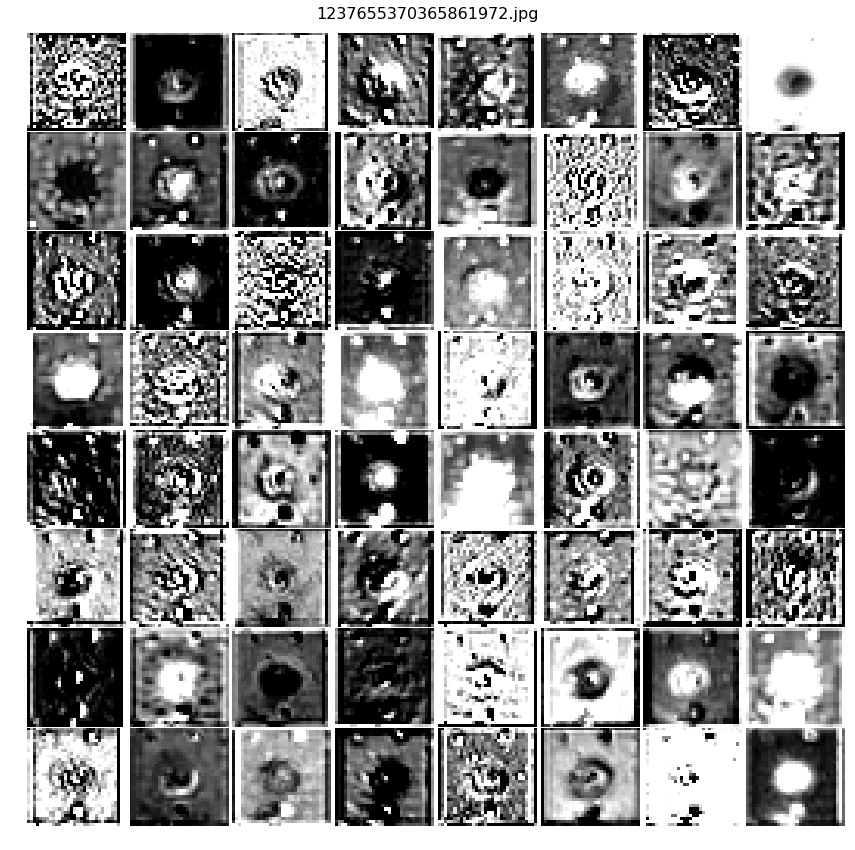

In [42]:
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

image_num = 42

for i, ax in enumerate(axes.flat):
    ax.imshow(all_layer6[image_num - 1, i, :], origin='upper', vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01, top=0.95)
fig.suptitle(f'{os.path.basename(fn)}', fontsize=16);

There's probably something that can be done using PCA here...

## Layer 6, channel 10

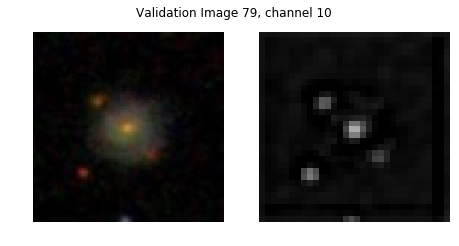

In [43]:
chan = 10
inum = 79

plot_lay6_image_pairs(inum - 1, chan - 1)

Here's something interesting -- does channel 10 not see the disk here?

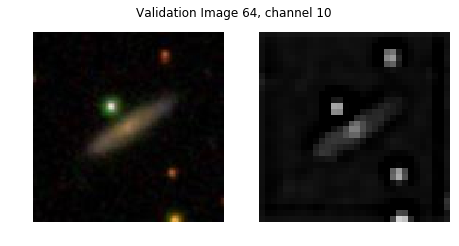

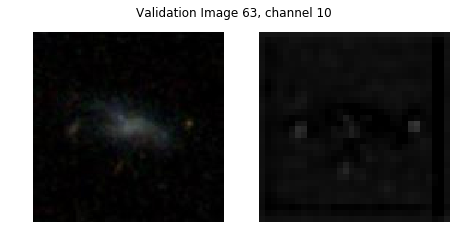

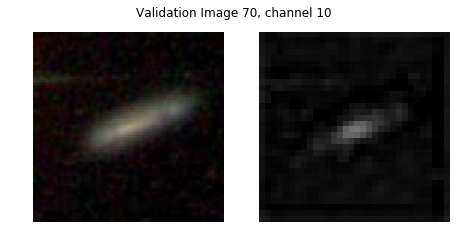

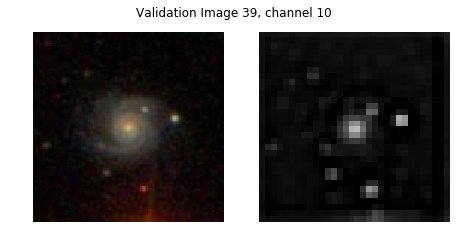

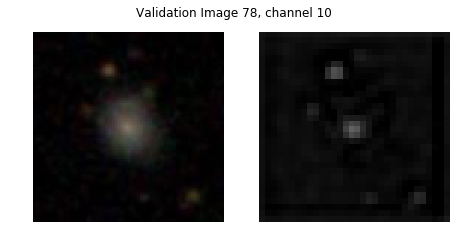

In [44]:
chan = 10
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan - 1)

Hmm, it's not only a point source finder.

## Layer 6, channel 16

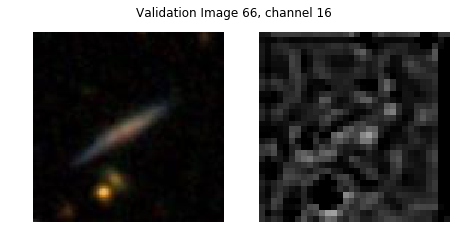

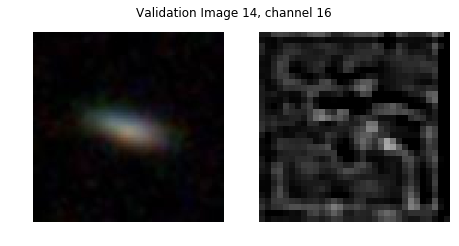

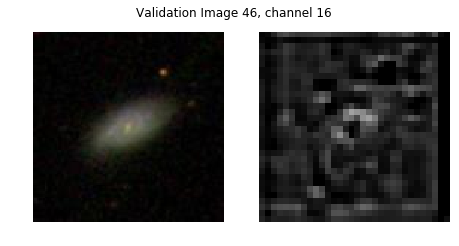

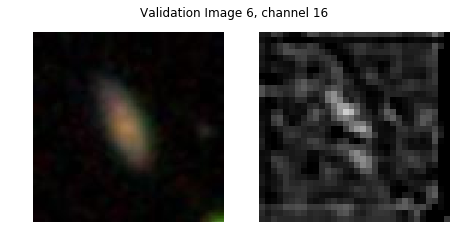

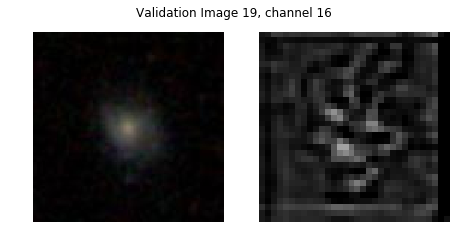

In [45]:
chan = 16
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan - 1)

Some sort of multipole moment?

## Layer 6, channel 35

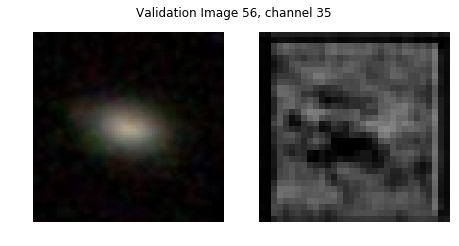

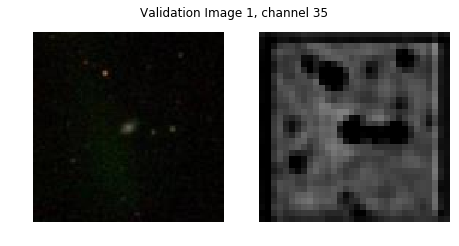

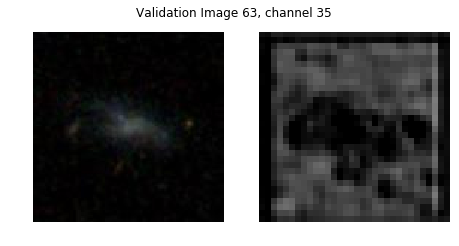

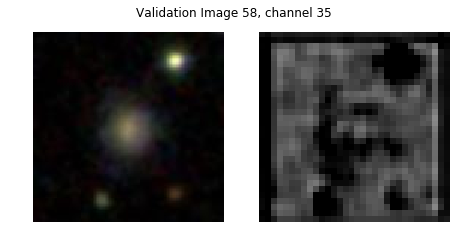

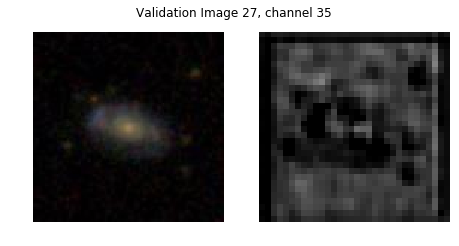

In [46]:
chan = 35
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan - 1)

# PCA visualization of layer 6 activations

In [48]:
from sklearn import decomposition

In [49]:
layer6_channel10 = all_layer6[:, 10 - 1].reshape(80, -1)

In [52]:
layer6_pca = decomposition.PCA(n_components=2,).fit_transform(layer6_channel10)
pca_df = pd.DataFrame(layer6_pca, columns=['x','y'])

In [54]:
pca_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
pca_df.set_index('fname', drop=True, inplace=True)

In [55]:
pca_df = pca_df.join(df, on='fname')

Text(0.5,1,'Layer 6, channel 35 (PCA vs. metallicity)')

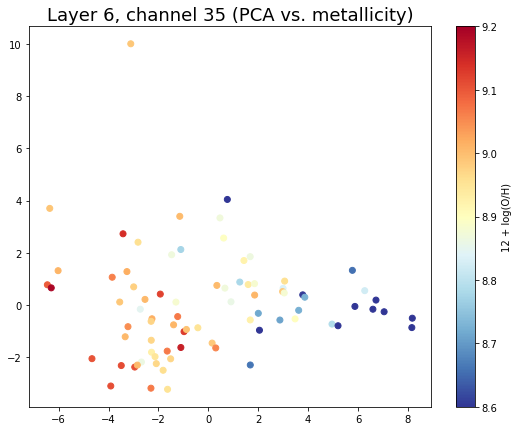

In [56]:
plt.figure(figsize=(9, 7))
sc = plt.scatter('x', 'y', data=pca_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title('Layer 6, channel 35 (PCA vs. metallicity)', fontsize=18)

In [57]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [81]:
def offset_image(fname, zoom=0.2):
    return OffsetImage(open_image(f'/home/john/projects/convnets-galaxy-metallicities-tsne/train/{fname}.jpg'), zoom=zoom)

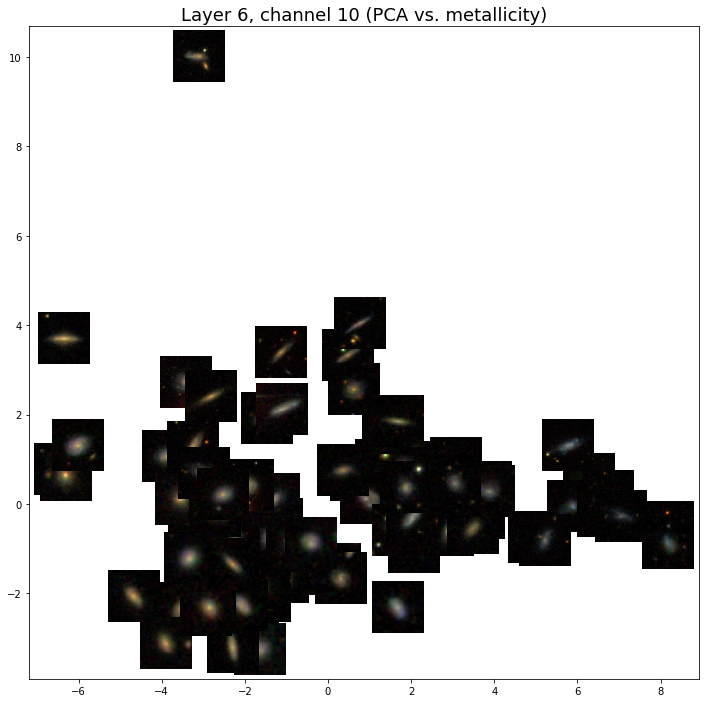

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter('x', 'y', data=pca_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')

plt.title('Layer 6, channel 10 (PCA vs. metallicity)', fontsize=18)

artists = []
for fname, [x, y, Z] in pca_df.iterrows():
    ab = AnnotationBbox(offset_image(fname, zoom=0.4), (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))

# t-SNE visualization of layer 6 activations

## Reduce dimensionality of layer 6, channel 35

In [87]:
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import squareform

import seaborn as sns

In [88]:
all_layer6.shape

(80, 64, 32, 32)

In [89]:
layer6_channel35 = all_layer6[:, 35 - 1].reshape(80, -1)

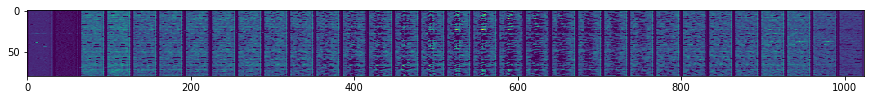

In [90]:
plt.figure(figsize=(15, 4))
plt.imshow(layer6_channel35,)

In [91]:
# do t-SNE transform
layer6_tsne = manifold.TSNE(n_components=2, perplexity=15).fit_transform(layer6_channel35)
tsne_df = pd.DataFrame(layer6_tsne, columns=['x','y'])

In [92]:
tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df.set_index('fname', drop=True, inplace=True)

In [93]:
tsne_df.head()

x          y
fname                                    
1237665441525596194 -31.552729  32.780853
1237674289683300721  -1.413025 -60.427597
1237668336326672889 -17.782759   6.645795
1237655370365861972  12.540361 -14.060791
1237662238015946871  45.969128  24.335697

In [94]:
# get truth labels
tsne_df = tsne_df.join(df, on='fname')
tsne_df.sample(5)

x          y    oh_p50
fname                                              
1237658299533885597  -9.665787  52.503368  9.004936
1237662196140802186 -39.944183 -35.653584  9.049955
1237662335714984017  49.790764  60.031258  8.882809
1237652900224499902 -35.891380 -44.904694  9.111347
1237668365852672491  39.062302  33.789051  8.956573

Text(0.5,1,'Layer 6, channel 35 (t-SNE vs. metallicity)')

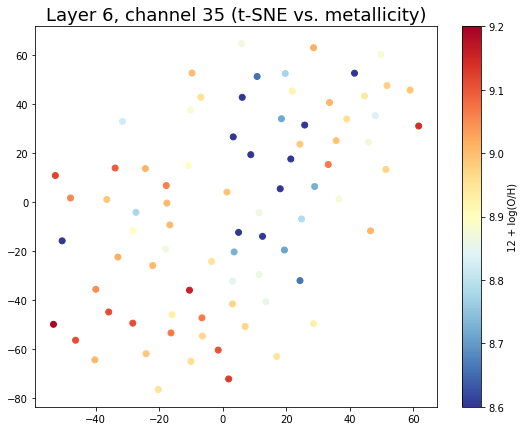

In [95]:
plt.figure(figsize=(9, 7))
sc = plt.scatter('x', 'y', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title('Layer 6, channel 35 (t-SNE vs. metallicity)', fontsize=18)

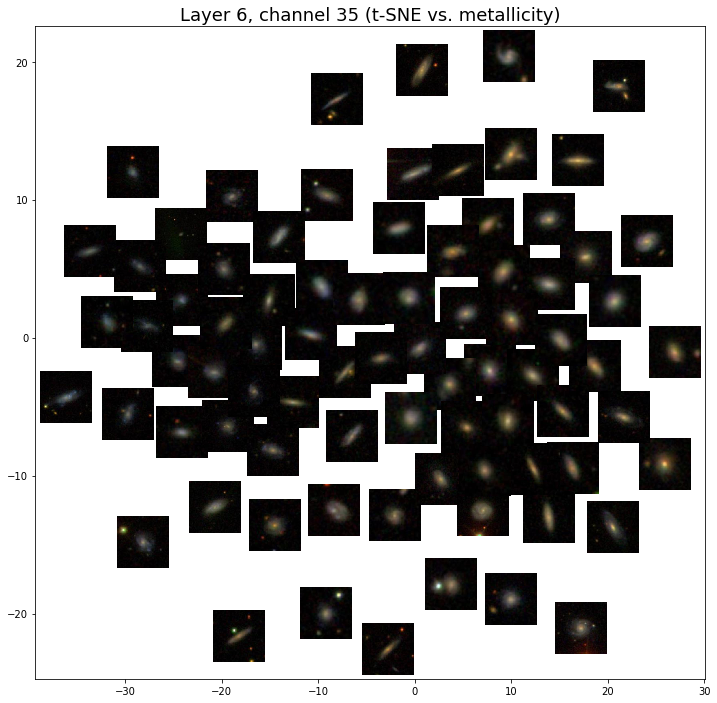

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter('x', 'y', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')

plt.title('Layer 6, channel 35 (t-SNE vs. metallicity)', fontsize=18)

artists = []
for fname, [x, y, Z] in tsne_df.iterrows():
    ab = AnnotationBbox(offset_image(fname, zoom=0.4), (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))

## (*) Use layer 6, channel 10

In [109]:
chan = 10

layer6_channel10 = all_layer6[:, chan - 1].reshape(80, -1)

In [110]:

layer6_tsne = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=256).fit_transform(layer6_channel10)
tsne_df = pd.DataFrame(layer6_tsne, columns=['x','y'])

In [111]:
tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')

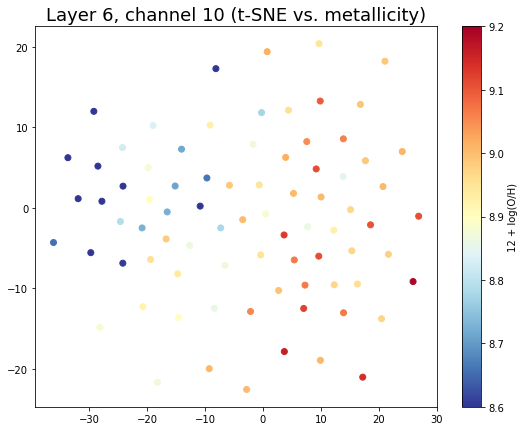

In [112]:
plt.figure(figsize=(9, 7))
sc = plt.scatter('x', 'y', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title(f'Layer 6, channel {chan} (t-SNE vs. metallicity)', fontsize=18);

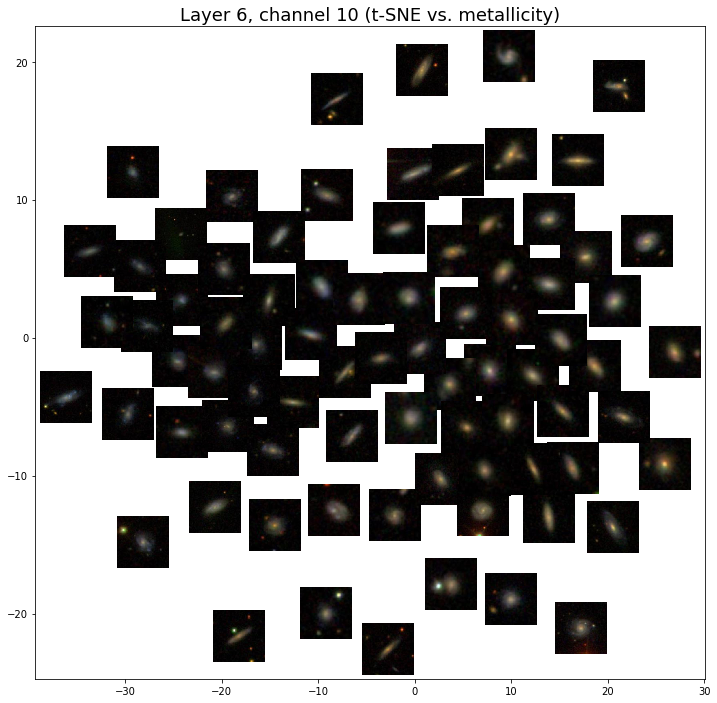

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter('x', 'y', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')

plt.title('Layer 6, channel 10 (t-SNE vs. metallicity)', fontsize=18)

artists = []
for fname, [x, y, Z] in tsne_df.iterrows():
    ab = AnnotationBbox(offset_image(fname, zoom=0.4), (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))

## (*) Try all channels in layer 6

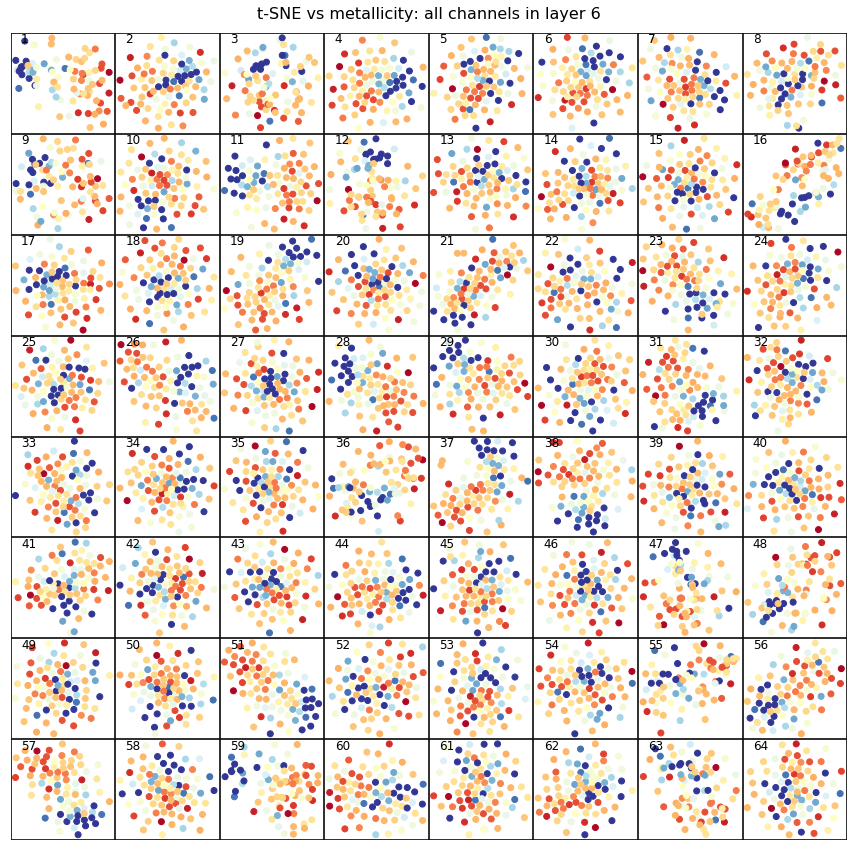

In [143]:
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

for chan, ax in tqdm_notebook(enumerate(axes.flat), total=64):
    flat_channel = all_layer6[:, chan - 1].reshape(80, -1)
    
    # t-SNE stuff
    tsne_chan = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=256).fit_transform(flat_channel)
    tsne_df = pd.DataFrame(tsne_chan, columns=['x','y'])
    tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
    tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')
    
    ax.scatter('x', 'y', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
    ax.text(0.1, 0.9, f'{chan + 1}', transform=ax.transAxes, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01, top=0.95)
fig.suptitle('t-SNE vs metallicity: all channels in layer 6', fontsize=16);



## Try layer 6, channel 10 using t-SNE distances

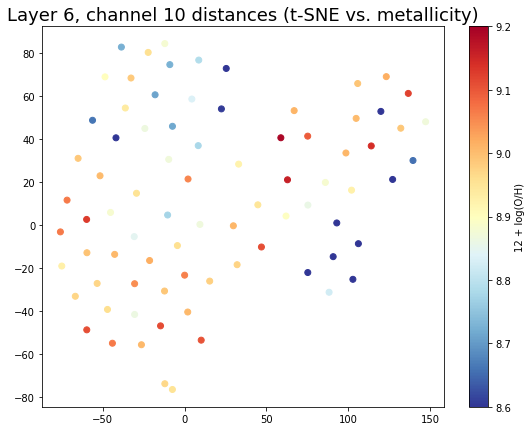

In [116]:
distances_chan10 = pairwise_distances(layer6_channel10)

layer10_dist_tsne = manifold.TSNE(n_components=2, perplexity=30).fit_transform(distances_chan10)
tsne_df = pd.DataFrame(layer10_dist_tsne, columns=['d1','d2'])

tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')

plt.figure(figsize=(9, 7))
sc = plt.scatter('d1', 'd2', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title(f'Layer 6, channel 10 distances (t-SNE vs. metallicity)', fontsize=18);

That's cool too, I guess

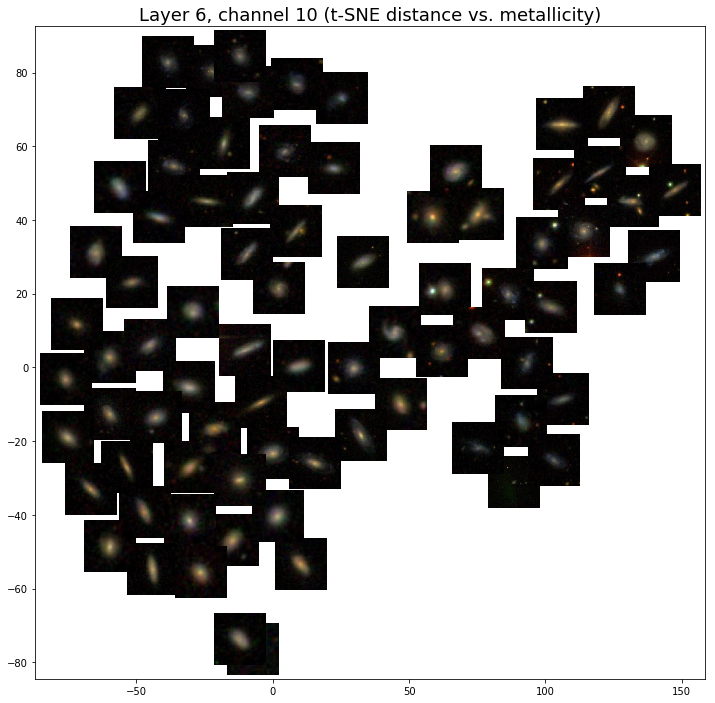

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter('d1', 'd2', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')

plt.title('Layer 6, channel 10 (t-SNE distance vs. metallicity)', fontsize=18)

artists = []
for fname, [x, y, Z] in tsne_df.iterrows():
    ab = AnnotationBbox(offset_image(fname, zoom=0.4), (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))

# Final conv layer activations


In [121]:
all_final = np.empty((80, 1024), dtype=np.float32)

for i in tqdm_notebook(range(len(data.val_ds))):
    all_final[i] = retrieve_layer(fns[i], layer=len(layer_outputs)).flatten()
    

In [122]:
all_final.shape

(80, 1024)

Note that the final convolution layer which results in size (80, 1024, 1, 1) is due to the adaptive MaxPool + adaptive AvgPool layers (which are concatenated)...

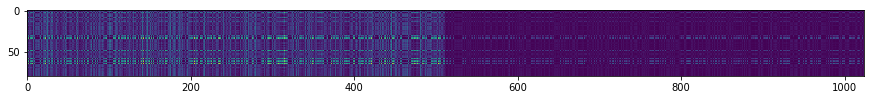

In [123]:
plt.figure(figsize=(15, 4))
plt.imshow(all_final,)

## Pairwise distances in final conv layer

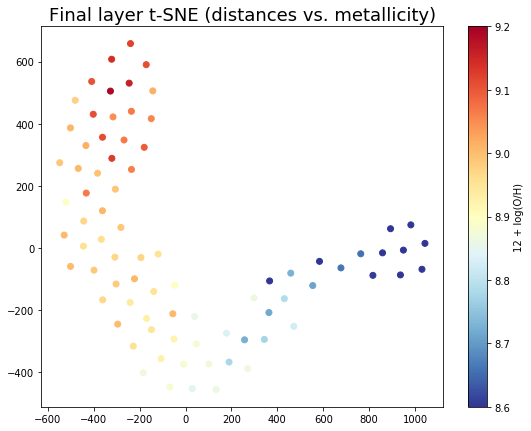

In [124]:
dists = pairwise_distances(all_final)

final_layer_tsne = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=256).fit_transform(dists)
tsne_df = pd.DataFrame(final_layer_tsne, columns=['d1','d2'])

tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')

plt.figure(figsize=(9, 7))
sc = plt.scatter('d1', 'd2', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title(f'Final layer t-SNE (distances vs. metallicity)', fontsize=18);

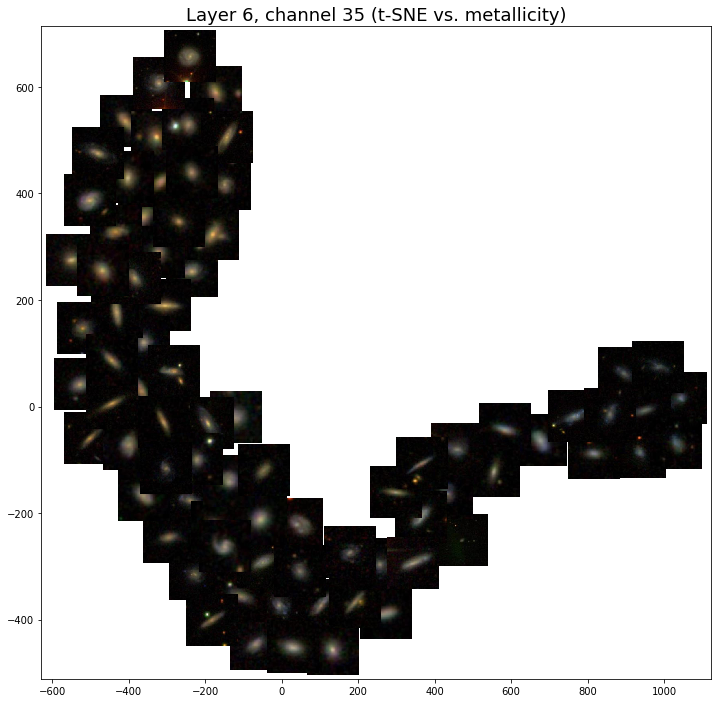

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter('d1', 'd2', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')

plt.title('Layer 6, channel 35 (t-SNE vs. metallicity)', fontsize=18)

artists = []
for fname, [x, y, Z] in tsne_df.iterrows():
    ab = AnnotationBbox(offset_image(fname, zoom=0.4), (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))

## Pure t-SNE 

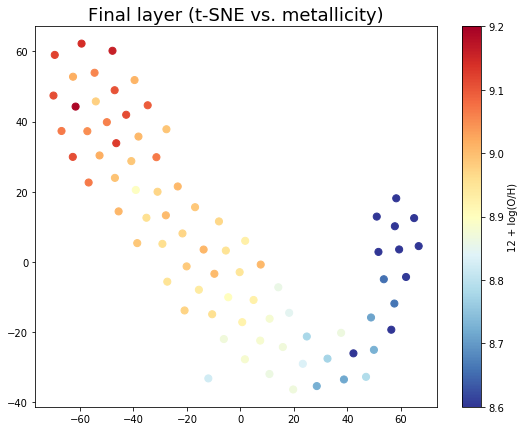

In [142]:

final_layer_tsne = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=256).fit_transform(all_final)
tsne_df = pd.DataFrame(final_layer_tsne, columns=['d1','d2'])

tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')

plt.figure(figsize=(9, 7))
sc = plt.scatter('d1', 'd2', data=tsne_df, c='oh_p50', s=50, vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title(f'Final layer (t-SNE vs. metallicity)', fontsize=18);

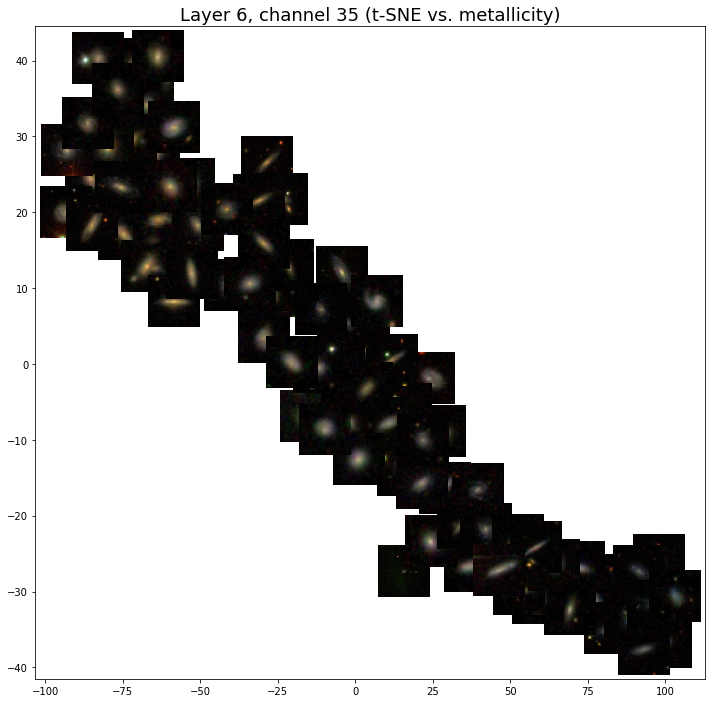

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter('d1', 'd2', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')

plt.title('Layer 6, channel 35 (t-SNE vs. metallicity)', fontsize=18)

artists = []
for fname, [x, y, Z] in tsne_df.iterrows():
    ab = AnnotationBbox(offset_image(fname, zoom=0.4), (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))

In [ ]:
off